In [1]:
!pip install gigalens

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 27.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.8/30.8 MB 10.7 MB/s eta 0:00:00
ERROR: Operation cancelled by user


In [1]:
!pip install corner

In [2]:
import matplotlib as mpl
import numpy as np
import seaborn as sns
import tensorflow as tf
import tensorflow_probability as tfp
from matplotlib import pyplot as plt
from corner import corner

"""from gigalens.tf.inference import ModellingSequence
from gigalens.tf.model import ForwardProbModel, BackwardProbModel
from gigalens.model import PhysicalModel
from gigalens.tf.simulator import LensSimulator
from gigalens.simulator import SimulatorConfig
from gigalens.tf.profiles.light import sersic
from gigalens.tf.profiles.mass import epl, shear"""

sns.set_style("whitegrid")
tfd = tfp.distributions

In [3]:
line_prior = tfd.JointDistributionNamed(
                  dict(
                      slope=tfd.Uniform(-10,10),
                      y_intercept=tfd.Uniform(-10,10),
                  )
              )


In [4]:
line_prior.sample(2)

{'y_intercept': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([ 0.70957375, -0.14593315], dtype=float32)>,
 'slope': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([9.246218 , 2.2606182], dtype=float32)>}

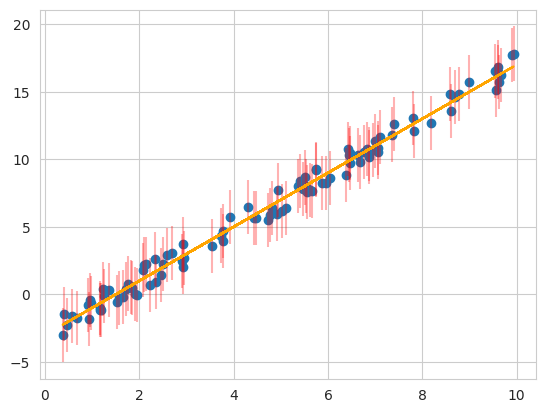

<tf.Tensor: shape=(2,), dtype=int32, numpy=array([100,   4], dtype=int32)>

In [123]:
import random

# define truth parameters and noisy data

m = 2.0
b = -3.0
err = 2.0

num_points = 100

x_observed = []
for i in range(num_points):
  x = random.uniform(0,10)
  x_observed.append(x)

x_observed = tf.cast(tf.constant(x_observed),tf.float32)
m = tf.cast(tf.constant([m]),tf.float32)
b = tf.cast(tf.constant([b]),tf.float32)
err = tf.cast(tf.constant(err), tf.float32)

@tf.function
def line_model(x,params):
  m,b = params
  mx = tf.tensordot(m,x,axes=0)
  b_ = b[:,None]
  y = mx + b_
  return y

def line_noisy(x,params):
  m,b = params
  return line_model(x,(m,b)) + random.uniform(-1,1)

y_observed = [line_noisy(x,(m,b)) for x in x_observed]
y_observed = np.array(y_observed).flatten()
y_observed = tf.cast(tf.constant(y_observed),tf.float32)

# plot data points and truth line

x_observed_c = tf.reshape(x_observed,(num_points))
y_observed_c = tf.reshape(y_observed,(num_points))

plt.scatter(x_observed_c,y_observed_c)
plt.errorbar(x_observed_c, y_observed_c, yerr = err, marker = 's', fmt = 'None', ecolor = 'red', alpha = 0.3)
plt.plot(x_observed_c, tf.reshape(line_model(x_observed, (m,b)),(num_points)), color = 'orange')
plt.show()

ms = tf.constant([1.0,-2.0,3.0,4.0])
bs = tf.constant([1.0,3.0,2.0,4.0])

tf.shape(tf.reshape(line_model(x_observed, (ms,bs)), (num_points,-1)))



In [124]:
@tf.function
def log_prob(x_observed, y_observed, m, b):
  y_model = tf.reshape(line_model(x_observed, (m,b)), (num_points,-1))
  y_model = tf.reshape(y_model,(len(m),num_points))
  #print(y_model)
  errs = tf.constant(err, shape=(len(m),num_points))
  #print(errs)
  #y_observed_ = y_observed[None,:]
  #print(tfd.Independent(tfd.Normal(y_model, errs)))
  log_like = tfd.Independent(tfd.Normal(y_model, errs), reinterpreted_batch_ndims=None).log_prob(y_observed)
  #print(y_observed)
  #print(log_like)
  log_prior = line_prior.log_prob(dict(slope=m,y_intercept=b))
  #print(log_prior)

  return log_like + log_prior, tf.reduce_mean((y_observed - line_model(x_observed,(m,b)))/errs, axis = 1)**2


In [125]:
ms = tf.constant([1.0,2.0,3.0,4.0])
bs = tf.constant([1.0,-3.0,2.0,4.0])
lps, square_errs = log_prob(x_observed, y_observed, ms, bs)
square_errs

<tf.Tensor: shape=(4,), dtype=float32, numpy=
array([1.2318712e-01, 8.8595400e-05, 2.3715000e+01, 6.7736160e+01],
      dtype=float32)>

In [132]:
from tqdm.auto import trange, tqdm

class ModellingSequence():
    def __init__(self, x_observed, y_observed):
        self.x_observed = x_observed
        self.y_observed = y_observed

    def MAP(self, optimizer, start=None, n_samples=500, num_steps=350, seed=0):
        tf.random.set_seed(seed)
        #start = self.prob_model.prior.sample(n_samples) if start is None else start
        start = line_prior.sample(n_samples)
        ms = start['slope']
        bs = start['y_intercept']
        ms_train = tf.Variable(ms, trainable = True)
        bs_train = tf.Variable(bs, trainable = True)
        #print(trial)

        @tf.function
        def train_step():
            with tf.GradientTape() as tape:
                log_probability, square_err = log_prob(self.x_observed, self.y_observed, ms_train, bs_train)
                agg_loss = tf.reduce_mean(-log_probability / len(x_observed))
            gradients = tape.gradient(agg_loss, [ms_train,bs_train])
            optimizer.apply_gradients(zip(gradients, [ms_train,bs_train]))
            #return log_probability
            return square_err

        with trange(num_steps) as pbar:
            for _ in pbar:
                square_err = train_step()
                pbar.set_description(f"Chi Squared: {(np.nanmin(square_err)):.8f}")
        return ms_train, bs_train

      def SVI(self, optimizer, start, n_vi=250, init_scales=1e-3, num_steps=500, seed=2):
          tf.random.set_seed(seed)

          start = tf.squeeze(start)
          scale = (
            np.ones(len(start)).astype(np.float32) * init_scales
            if np.size(init_scales) == 1
            else init_scales
          )
          q_z = tfd.MultivariateNormalTriL(
            loc=tf.Variable(start),
            scale_tril=tfp.util.TransformedVariable(
                np.diag(scale),
                tfp.bijectors.FillScaleTriL(diag_bijector=tfb.Exp(), diag_shift=1e-6),
                name="stddev",
            ),
          )




In [127]:
fitter = ModellingSequence(x_observed, y_observed)

In [128]:
schedule_fn = tf.keras.optimizers.schedules.PolynomialDecay(3e0, 500, 1e0)
optimizer = tf.keras.optimizers.Adam(schedule_fn)
MAP = fitter.MAP(optimizer=optimizer, n_samples=500, num_steps=300, seed=0)

  0%|          | 0/300 [00:00<?, ?it/s]

In [131]:
ms_train, bs_train = MAP
lps = log_prob(x_observed, y_observed, ms_train, bs_train)[0]
best_idx = tf.argmax(lps).numpy()
MAP_m = ms_train[best_idx].numpy()
MAP_b = bs_train[best_idx].numpy()

MAP_m, MAP_b

(2.0108476, -3.0700295)